## Random Forest Implementation on scaled reduced dataset with PCA

Imports

In [1]:
# Utilities
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt

# Models
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

C:\Users\movil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Set random seed for reproductibility

In [2]:
seed = 23

Read clean (scaled data)

In [3]:
df_scaled = pd.read_csv('../../Data/dataset_preprocessed.csv')

Read Train Data

In [4]:
columns_PCA = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
           'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18']

In [5]:
X_train= pd.read_csv('../../DimensionalityReductionData/X_train_PCA.csv', names=columns_PCA)
X_train.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
0,0.230656,-0.540199,0.275241,0.348734,0.442168,-0.244893,-0.305579,-0.388014,0.483440,-0.050057,0.114171,0.037729,-0.133432,0.084029,0.211571,-0.000299,0.276030,0.133585
1,-0.578532,-0.273813,-0.207024,0.202237,0.438744,-0.422858,0.108360,-0.469457,0.476055,0.098184,0.022312,0.125669,0.187688,-0.019637,-0.181937,-0.064250,-0.107400,0.057437
2,-0.207271,1.096294,-0.124524,-0.014919,0.302102,0.276747,0.024807,-0.079499,0.016929,0.018033,-0.071089,-0.003510,-0.020689,-0.065503,-0.117356,-0.056667,-0.133169,-0.121348
3,-0.549501,-0.271749,0.166219,0.161220,0.278617,-0.671476,-0.287128,0.591844,-0.668737,-0.173965,-0.421168,-0.101647,-0.332900,-0.157359,0.086729,0.130933,-0.221770,-0.134654
4,-0.605220,-0.210550,-0.406984,0.455269,-0.336895,0.182399,0.298030,0.309622,0.071143,-0.035126,0.191219,-0.142084,0.191455,0.036069,-0.138503,0.001297,-0.030649,0.106555


Read Test Data

In [6]:
X_test = pd.read_csv('../../DimensionalityReductionData/X_test_PCA.csv', names=columns_PCA)
X_test.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
0,0.325189,-0.474065,0.148350,0.015025,0.453967,-0.382437,0.009063,0.696200,-0.577426,-0.029937,-0.099144,0.654157,0.475839,0.289828,-0.034359,-0.584359,0.783886,-0.206918
1,-0.553038,-0.060147,0.246432,-0.094217,-0.152499,-0.133879,0.046601,-0.127948,-0.063073,-0.262155,0.036293,-0.084048,-0.114584,0.030450,0.102251,-0.048580,0.100263,0.069443
2,-0.543513,-0.099255,0.273981,-0.140697,-0.202855,-0.145719,-0.165479,-0.040533,-0.045461,-0.230001,0.047889,-0.076919,-0.013481,0.034937,0.047416,-0.038551,0.040234,0.096922
3,0.604992,0.850389,0.205670,0.134501,0.422158,0.448003,-0.124164,-0.002779,0.023872,-0.005055,-0.010426,-0.033946,-0.181834,0.042114,0.137483,0.011521,0.138021,0.009279
4,-0.222045,1.101761,-0.093482,-0.005867,0.283825,0.294311,0.032426,-0.116046,0.009989,-0.017200,-0.072850,-0.009081,-0.097862,-0.067777,-0.070239,-0.058562,-0.076902,-0.149065


Do Train-Test Split to define y_train, y_test (both are raings)
!!!! IMPORTANT use random_state as defined in Dimension Reduction DATA SPLIT!!!!

In [7]:
y_train, y_test = train_test_split(df_scaled['averageRating'], test_size=0.2, random_state=42)

Now everything is defined (X_train, X_test, y_train, y_test)

Save and print metrics

In [8]:
def calculate_metrics(model_name, y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Weighted F1': f1_score(y_true, y_pred, average='weighted'),
        'Weighted Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'Weighted Recall': recall_score(y_true, y_pred, average='weighted'),
        'Macro-Averaged Precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Macro-Averaged Recall': recall_score(y_true, y_pred, average='macro'),
        'F1': str(f1_score(y_true, y_pred, average=None)),
        'Precision': str( precision_score(y_true, y_pred, average=None, zero_division=0)),
    }
    
    # Print the metrics
    print(f"Metrics for {model_name}:")
    for metric_name, metric_value in metrics.items():
        try:
            print(f"{metric_name}: {metric_value:.4f}")
        except:
            print(f"{metric_name}: {metric_value}")
    
    # Print the classification report
    print("classification report")
    report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'], zero_division=0)
    print(report)

    print("Confusion Matrix")
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmd.plot()
    
    plt.title(f'Confusion matrix for model {model_name} (Accuracy:{metrics["Accuracy"]:.4f})')
    plt.show()
    
    # Create df to store metrics
    df_metrics = pd.DataFrame(metrics, index=[model_name])
    
    return df_metrics

In [9]:
model = RandomForestClassifier(n_estimators=100, random_state=seed)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))

print("F1 score:", f1_score(y_test, predictions, average=None))

Accuracy: 0.7331778814123917
F1 score: [0.73866232 0.72745832]


## Grid Search CV - 1

In [10]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Method of selecting samples for training each tree
}

model = RandomForestClassifier(random_state=seed)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("The parameters with the highest score: ", grid_search.best_params_)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
The parameters with the highest score:  {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [11]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)

# Show top 10 parameters for this model
minimalistic_results = cv_results_df[['params', 'mean_test_score']]
sorted_results = minimalistic_results.sort_values(by='mean_test_score', ascending=False)

print(sorted_results.head(10))

                                                params  mean_test_score
42   {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.727614
55   {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.727364
207  {'bootstrap': False, 'max_depth': 10, 'min_sam...         0.727280
211  {'bootstrap': False, 'max_depth': 10, 'min_sam...         0.727280
70   {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.727031
59   {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.726864
51   {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.726864
71   {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.726780
190  {'bootstrap': False, 'max_depth': 10, 'min_sam...         0.726780
43   {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.726697


Metrics for RF-PCA-GS-CV1:
Accuracy: 0.7342
Weighted F1: 0.7339
Weighted Precision: 0.7343
Weighted Recall: 0.7342
Macro-Averaged Precision: 0.7344
Macro-Averaged Recall: 0.7335
F1: [0.74602164 0.721174  ]
Precision: [0.73112913 0.73766976]
classification report
              precision    recall  f1-score   support

     Class 0       0.73      0.76      0.75      1539
     Class 1       0.74      0.71      0.72      1463

    accuracy                           0.73      3002
   macro avg       0.73      0.73      0.73      3002
weighted avg       0.73      0.73      0.73      3002

Confusion Matrix


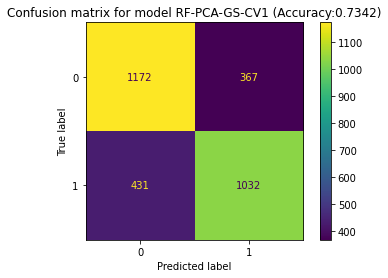

In [12]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
_ = calculate_metrics('RF-PCA-GS-CV1', y_test, predictions)

In [13]:
# Predicting using other alternatives of fine-tuning from top 10 performances
other_alternatives = []
# Choose a set of parameters from sorted_results
for i in range(10):

  params = sorted_results.iloc[i]['params']
  print("Parameters from place: ", i, " ", params)

  model = RandomForestClassifier(random_state=seed, **params)
  model.fit(X_train, y_train)

  predictions = model.predict(X_test)

  chosen_accuracy = accuracy_score(y_test, predictions)
  print("Accuracy for chosen parameters:", chosen_accuracy)
  other_alternatives.append((chosen_accuracy,params))


Parameters from place:  0   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy for chosen parameters: 0.7341772151898734
Parameters from place:  1   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for chosen parameters: 0.7348434377081945
Parameters from place:  2   {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy for chosen parameters: 0.740506329113924
Parameters from place:  3   {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for chosen parameters: 0.740506329113924
Parameters from place:  4   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy for chosen parameters: 0.7391738840772818
Parameters from place:  5   {'bootstrap': True, 'max_depth': 10, 'min_samples_l

In [14]:
# get best from top 10
best_tuple = max(other_alternatives, key=lambda x: x[0])

In [15]:
print("Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances")
print(best_tuple[0])
print(best_tuple[1])

Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances
0.740506329113924
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


In [16]:
# Run on training sample

# Choose a set of parameters from sorted_results
for i in range(10):

  params = sorted_results.iloc[i]['params']
  print("Parameters from place: ", i, " ", params)

  model = RandomForestClassifier(random_state=42, **params)
  model.fit(X_train, y_train)

  predictions = model.predict(X_train)

  chosen_accuracy = accuracy_score(y_train, predictions)
  print("Accuracy for chosen parameters:", chosen_accuracy)

Parameters from place:  0   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy for chosen parameters: 0.8089962515618492
Parameters from place:  1   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


KeyboardInterrupt: 

In [ ]:
accuracies=[]
max_depths=[]
for i in reversed(range(1,15)):
  model = RandomForestClassifier(random_state=seed, max_depth=i)
  model.fit(X_train, y_train)
  predictions = model.predict(X_train)
  accuracy = accuracy_score(y_train, predictions)
  max_depths.append(i)
  accuracies.append(accuracy)
  print("Accuracy for max depth :", i, " ", accuracy)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(max_depths, accuracies, marker='o', linestyle='-', color='b')

plt.title('Accuracy related to the maximum depth of the model')
plt.xlabel('Maximum depth')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

Classification report of best model from alternatives of fine tuning

In [ ]:
model = RandomForestClassifier(random_state=seed, **best_tuple[1])
model.fit(X_train, y_train)

predictions = model.predict(X_test)
current_accuracy = accuracy_score(y_test, predictions)

report = classification_report(y_test, predictions, output_dict=True, zero_division=0)


In [ ]:
print(classification_report(y_test, predictions, zero_division=0))

In [ ]:
calculate_metrics('RF-PCA-alternatives', y_test, predictions)